# OSMnx

Testing the [OSMnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) library for loading and processing OSM data.

See these [notebooks](https://github.com/gboeing/osmnx-examples/tree/master/notebooks) for examples of using the library.

In [12]:
# !brew install spatialindex

In [13]:
import networkx as nx
import itertools
import osmnx as ox
import glob
import itertools
from matplotlib import cm
import folium
import matplotlib.pyplot as plt
import time
import numpy as np
from osmnx.save_load import graph_to_gdfs
from matplotlib.collections import LineCollection
from torch_geometric.utils import from_networkx


%matplotlib inline
ox.config(log_console=True, use_cache=True, data_folder='')

In [23]:
graphml_fnames = glob.glob('data/boeing_dataverse/06-CA-cities-street_networks-graphml/*.graphml')

In [24]:
def remove_parallels(G):
    parallel_edges = [(u, v, key) for (u, v, key) in G.edges(keys=True) if key != 0]
    G.remove_edges_from(parallel_edges)

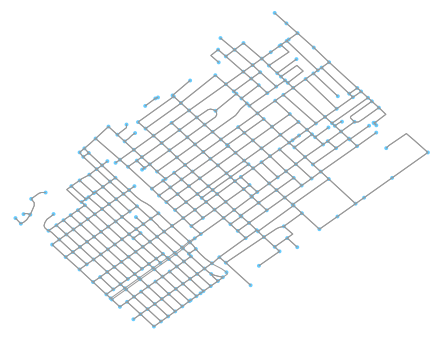

06_CA_0666140_San_Fernando


In [32]:
M = ox.load_graphml(graphml_fnames[16])
remove_parallels(M)
fig, ax = ox.plot_graph(M)
G = nx.Graph(M)
print(G.graph['name'])

In [33]:
G = nx.Graph()
featureList = ['osmid','name','highway','lanes','length']
for u,v,data in M.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G.has_edge(u,v):
        G[u][v]['weight'] += w
    else:
        G.add_edge(u, v, weight=w)
new_attributes = {}
for u,v,data in M.edges(data=True):
    if 'oneway' in data.keys():
        data['oneway'] = int(data['oneway'])
    if 'lanes' not in data.keys():
        data['lanes'] = ['1']
    if isinstance(data['lanes'], int):
        data['lanes'] = [data['lanes']]
    for i in data['lanes']:
        if isinstance(i, list):
            i = [int(j) for j in i]
            i = max(i)
        i = int(i)
    data['lanes'] = [int(i) for i in data['lanes']] 
    data['lanes'] = max(data['lanes'])
    keys = list(data.keys())
    for key in keys:
        if key not in featureList:
            data.pop(key, None)
    new_attributes[(u,v)] = data
    print(data)
#for data in G.nodes(data=True):
    #print(data)
nx.classes.function.set_edge_attributes(G,new_attributes)
pyData = from_networkx(G)
print(pyData.num_edge_features)
print(type(G))

{'osmid': 13280097, 'name': 'Lucas Street', 'highway': 'residential', 'length': 101.218, 'lanes': 1}
{'osmid': 13452326, 'name': 'North Brand Boulevard', 'highway': 'residential', 'length': 51.964, 'lanes': 1}
{'osmid': 13452326, 'name': 'North Brand Boulevard', 'highway': 'residential', 'length': 199.596, 'lanes': 1}
{'osmid': 13280097, 'name': 'Lucas Street', 'highway': 'residential', 'length': 39.393, 'lanes': 1}
{'osmid': 13280097, 'name': 'Lucas Street', 'highway': 'residential', 'length': 101.218, 'lanes': 1}
{'osmid': 13324459, 'name': 'Macneil Street', 'highway': 'residential', 'length': 150.548, 'lanes': 1}
{'osmid': 13280097, 'name': 'Lucas Street', 'highway': 'residential', 'length': 108.571, 'lanes': 1}
{'osmid': 13280097, 'name': 'Lucas Street', 'highway': 'residential', 'length': 62.897, 'lanes': 1}
{'osmid': 400875429, 'lanes': 4, 'name': 'Maclay Street', 'highway': 'secondary', 'length': 99.223}
{'osmid': 400875429, 'lanes': 4, 'name': 'Maclay Street', 'highway': 'secon

TypeError: an integer is required (got type list)

In [34]:
#Turn into Line Graph
LG = nx.line_graph(G)
new_attr = {}
for key,_ in LG.nodes(data=True):
    new_attr[key] = G.get_edge_data(key[0],key[1])
nx.classes.function.set_node_attributes(LG,new_attr)
for key,data in LG.nodes(data=True):
    print(key,data)
#for key in LG.edges(data=True):
 #   print(key)


(122569354, 122844303) {'weight': 2.0, 'osmid': 13324459, 'name': 'Macneil Street', 'highway': 'residential', 'length': 150.548, 'lanes': 1}
(122569406, 123621119) {'weight': 2.0, 'osmid': [13440968, 13346204], 'name': ['Donnaglen Avenue', 'Fayecroft Street'], 'highway': 'residential', 'length': 183.309, 'lanes': 1}
(122589942, 122589945) {'weight': 2.0, 'osmid': 310370342, 'name': 'Newton Street', 'highway': 'residential', 'length': 215.791, 'lanes': 1}
(122589961, 122989277) {'weight': 2.0, 'osmid': 13350313, 'name': 'Newton Place', 'highway': 'residential', 'length': 7.866, 'lanes': 1}
(122589961, 3642362823) {'weight': 2.0, 'osmid': 359550906, 'highway': 'residential', 'length': 10.17, 'lanes': 1}
(122589961, 3642362821) {'weight': 2.0, 'osmid': 359550908, 'highway': 'residential', 'length': 30.82, 'lanes': 1}
(122601095, 373570550) {'weight': 2.0, 'osmid': 13284536, 'name': 'Warren Street', 'highway': 'residential', 'length': 169.773, 'lanes': 1}
(122727752, 123357101) {'weight': 

In [35]:
#Try doing regression on LG


In [36]:
def simulate_step(G_sim, edge_capacities):
    betw_cent = nx.edge_betweenness_centrality(G_sim, weight='length')
    
    failed = [(u, v) for (u, v, key) in G_sim.edges(keys=True)
                 if betw_cent[(u,v)] > edge_capacities[(u,v)]]
    
    G_sim.remove_edges_from(failed)
    
    return failed


def simulation(G, failed, edge_capacities, verbose=False):
    # note modifies G
    
    nx.set_edge_attributes(G, -1, 'failure_step')
    G_sim = G.copy()
    G_sim.remove_edges_from(failed)
     
    step = 0
    while len(failed) > 0:
        if verbose:
            print('stepping')
        nx.set_edge_attributes(G, {(u, v, 0): step for (u, v) in failed}, 'failure_step')
        failed = simulate_step(G_sim, edge_capacities)
        step += 1
        
    return step

In [37]:
def plot_graph(G, bbox=None, fig_height=6, fig_width=None, margin=0.02,
               axis_off=True, equal_aspect=False, bgcolor='w', show=True,
               save=False, close=True, file_format='png', filename='temp',
               dpi=300, annotate=False, node_color='#66ccff', node_size=15,
               node_alpha=1, node_edgecolor='none', node_zorder=1,
               edge_color='#999999', edge_linewidth=1, edge_alpha=1, edge_zorder=2,
               use_geom=True):

    #log('Begin plotting the graph...')
    node_Xs = [float(x) for _, x in G.nodes(data='x')]
    node_Ys = [float(y) for _, y in G.nodes(data='y')]

    # get north, south, east, west values either from bbox parameter or from the
    # spatial extent of the edges' geometries
    if bbox is None:
        edges = graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
        west, south, east, north = edges.total_bounds
    else:
        north, south, east, west = bbox

    # if caller did not pass in a fig_width, calculate it proportionately from
    # the fig_height and bounding box aspect ratio
    bbox_aspect_ratio = (north-south)/(east-west)
    if fig_width is None:
        fig_width = fig_height / bbox_aspect_ratio

    # create the figure and axis
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=bgcolor)
    ax.set_facecolor(bgcolor)

    # draw the edges as lines from node to node
    start_time = time.time()
    lines = []
    for u, v, data in G.edges(keys=False, data=True):
        if 'geometry' in data and use_geom:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    if not isinstance(edge_color, list):
        edge_color = [edge_color] * len(lines)
    if not isinstance(edge_linewidth, list):
        edge_linewidth = [edge_linewidth] * len(lines)
    if not isinstance(edge_alpha, list):
        edge_alpha = [edge_alpha] * len(lines)
    if not isinstance(edge_zorder, list):
        edge_zorder = [edge_zorder] * len(lines)
        
    for i in range(len(lines)):
        lc = LineCollection(lines[i:i+1],
                            colors=edge_color[i:i+1],
                            linewidths=edge_linewidth[i:i+1], #TODO FIX!
                            alpha=edge_alpha[i],
                            zorder=edge_zorder[i])
        ax.add_collection(lc)
    #log('Drew the graph edges in {:,.2f} seconds'.format(time.time()-start_time))

    # scatter plot the nodes
    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color, alpha=node_alpha, edgecolor=node_edgecolor, zorder=node_zorder)

    # set the extent of the figure
    margin_ns = (north - south) * margin
    margin_ew = (east - west) * margin
    ax.set_ylim((south - margin_ns, north + margin_ns))
    ax.set_xlim((west - margin_ew, east + margin_ew))

    # configure axis appearance
    xaxis = ax.get_xaxis()
    yaxis = ax.get_yaxis()

    xaxis.get_major_formatter().set_useOffset(False)
    yaxis.get_major_formatter().set_useOffset(False)

    # if axis_off, turn off the axis display set the margins to zero and point
    # the ticks in so there's no space around the plot
    if axis_off:
        ax.axis('off')
        ax.margins(0)
        ax.tick_params(which='both', direction='in')
        xaxis.set_visible(False)
        yaxis.set_visible(False)
        fig.canvas.draw()

    if equal_aspect:
        # make everything square
        ax.set_aspect('equal')
        fig.canvas.draw()
    else:
        # if the graph is not projected, conform the aspect ratio to not stretch the plot
        if G.graph['crs'] == ox.settings.default_crs:
            coslat = np.cos((min(node_Ys) + max(node_Ys)) / 2. / 180. * np.pi)
            ax.set_aspect(1. / coslat)
            fig.canvas.draw()

    # annotate the axis with node IDs if annotate=True
    if annotate:
        for node, data in G.nodes(data=True):
            ax.annotate(node, xy=(data['x'], data['y']))

    # save and show the figure as specified
    fig, ax = ox.save_and_show(fig, ax, save, show, close, filename, file_format, dpi, axis_off)
    return fig, ax

In [39]:
"""

betw_cent = nx.edge_betweenness_centrality(G, weight='length')
edge_capacities = {k: v * 1.5 for k, v in betw_cent.items()}

max_betw_cent_edge = max(betw_cent, key=betw_cent.get)
max_betw_cent = betw_cent[max_betw_cent_edge]

max_step = simulation(G, [max_betw_cent_edge], edge_capacities, verbose=True)
"""

"\n\nbetw_cent = nx.edge_betweenness_centrality(G, weight='length')\nedge_capacities = {k: v * 1.5 for k, v in betw_cent.items()}\n\nmax_betw_cent_edge = max(betw_cent, key=betw_cent.get)\nmax_betw_cent = betw_cent[max_betw_cent_edge]\n\nmax_step = simulation(G, [max_betw_cent_edge], edge_capacities, verbose=True)\n"

In [40]:
ec = ['lightgrey' if d['failure_step'] == -1 else cm.hot(1 - d['failure_step'] / max_step)
      for (u,v,d) in G.edges(data=True)]

ez = [d['failure_step'] + 1 for (u,v,d) in G.edges(data=True)]

fig, ax = plot_graph(G, edge_color=ec, fig_height=8,
                     annotate=False, use_geom=True, edge_linewidth=3,
                     edge_alpha=1, edge_zorder=ez)

TypeError: float() argument must be a string or a number, not 'NoneType'

In [41]:
# highlight all parallel edges in purple
ec = [cm.hot(betw_cent[(u,v)] / max_betw_cent) for u, v in G.edges()]
ez = np.argmin(np.argmax(np.array([cm.viridis(betw_cent[(u,v)] / max_betw_cent) for u, v in G.edges()])), )

fig, ax = plot_graph(G, edge_color=ec, fig_height=8,
                     annotate=False, use_geom=True, edge_linewidth=3,
                     edge_alpha=1, edge_zorder=ez)

TypeError: float() argument must be a string or a number, not 'NoneType'

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, task='node'):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.task = task
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = args.dropout
        self.num_layers = args.num_layers

    def build_conv_model(self, model_type):
        if model_type == 'GCN':
            return pyg_nn.GCNConv
        elif model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, one needs to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop when builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        ############################################################################
        # DONE
        # Each layer in GNN should consist of a convolution (specified in model_type),
        # a non-linearity (use RELU), and dropout. 
        # HINT: the __init__ function contains parameters you will need. For whole
        # graph classification (as specified in self.task) apply max pooling over
        # all of the nodes with pyg_nn.global_max_pool as the final layer.
        # Our implementation is ~6 lines, but don't worry if you deviate from this.
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        if self.task == 'graph':
            x = pyg_nn.global_max_pool(x, batch)
        # x = None # Todo
        ############################################################################

        x = self.post_mp(x)

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)


class GraphSage(pyg_nn.MessagePassing):
    """Non-minibatch version of GraphSage."""
    def __init__(self, in_channels, out_channels, reducer='mean', 
                 normalize_embedding=True):
        super(GraphSage, self).__init__(aggr='mean')

        ############################################################################
        # Done
        # Define the layers needed for the message and update functions below.
        # self.lin is the linear transformation that you apply to each neighbor before aggregating them
        # self.agg_lin is the linear transformation you apply to the concatenated self embedding (skip connection) and mean aggregated neighbors
        # Our implementation is ~2 lines, but don't worry if you deviate from this.

        self.agg_lin = nn.Linear(in_channels + out_channels, out_channels)
        self.lin = nn.Linear(in_channels, out_channels)

        ############################################################################

        if normalize_embedding:
            self.normalize_emb = True

    def forward(self, x, edge_index):
        num_nodes = x.size(0)
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        return self.propagate(edge_index, size=(num_nodes, num_nodes), x=x)

    def message(self, x_j, edge_index, size):
        # x_j has shape [E, in_channels]
        # edge_index has shape [2, E]
        
        ############################################################################
        # DONE: Your code here! 
        # Given x_j, perform the aggregation of a dense layer followed by a RELU non-linearity.
        # Notice that the aggregator operation will be done in self.propagate. 
        # HINT: It may be useful to read the pyg_nn implementation of GCNConv,
        # https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # Our implementation is ~1 line, but don't worry if you deviate from this.
        x_j = self.lin(x_j)
        x_j = F.relu(x_j)

        ############################################################################

        return x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]
        # x has shape [N, in_channels]
        
        ############################################################################
        # DONE: Your code here! Perform the update step here. 
        # Perform a MLP with skip-connection, that is a concatenation followed by 
        # a linear layer and a RELU non-linearity.
        # Finally, remember to normalize as vector as shown in GraphSage algorithm.
        # Our implementation is ~4 lines, but don't worry if you deviate from this.
        catted = torch.cat([aggr_out, x], dim=1)
        aggr_out = F.relu(self.agg_lin(catted))
        
        if self.normalize_emb:
            aggr_out = F.normalize(aggr_out)

        ############################################################################

        return aggr_out


class GAT(pyg_nn.MessagePassing):
    # Please run code with num_heads=1. 
    def __init__(self, in_channels, out_channels, num_heads=1, concat=True,
                 dropout=0, bias=True, **kwargs):
        super(GAT, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = num_heads
        self.concat = concat 
        self.dropout = dropout

        ############################################################################
        #  DONE: Your code here!
        # Use nn.Linear the layers needed for the forward function. 
        # Remember that the shape of the output depends on the number of heads and out_channels.
        # Our implementation is ~1 line, but don't worry if you deviate from this.

        self.lin = nn.Linear(self.in_channels, self.heads * self.out_channels) # None # TODO

        ############################################################################

        ############################################################################
        # DONE
        # The attention mechanism is a single feed-forward neural network parametrized
        # by weight vector self.att. Define self.att using nn.Parameter needed for the attention
        # mechanism here. Remember to consider number of heads and out_channels for dimension!
        # Also remember that that the attention mechanism is applied to the concatenation
        # of node feaures of two nodes for dimension.
        # Our implementation is ~1 line, but don't worry if you deviate from this.

        self.att = nn.Parameter(torch.ones(2*self.out_channels,self.heads ))

        ############################################################################

        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(self.heads * out_channels))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        nn.init.xavier_uniform_(self.att)
        nn.init.zeros_(self.bias)

        ############################################################################

    def forward(self, x, edge_index, size=None):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        ############################################################################
        #  DONE
        # Apply your linear transformation to the node feature matrix x before starting
        # to propagate messages.
        # Our implementation is ~1 line, but don't worry if you deviate from this.
        
        x = self.lin(x)
        ############################################################################

        # Start propagating messages.
        return self.propagate(edge_index, size=size, x=x)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Constructs messages to node i for each edge (j, i).
        # edge_index_i has shape [E]
        
        ############################################################################
        #  DONE
        # in equation (7). Remember to be careful of the number of heads with dimension!
        # HINT: torch_geometric.utils.softmax may help to calculate softmax for neighbors of i. 
        # https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.softmax
        # Our implementation is ~5 lines, but don't worry if you deviate from this.

        cat = torch.cat([x_i, x_j], dim=1)
        arg = torch.mm(cat, self.att)
        arg = F.leaky_relu(arg, negative_slope=0.2)
        alpha = pyg_utils.softmax(arg, edge_index_i, size_i)
        ############################################################################

        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        return x_j * alpha

    def update(self, aggr_out):
        # Updates node embedings.
        if self.concat is True:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)

        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out


In [49]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from matplotlib import pyplot as plt

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import *
from torch_geometric.data import DataLoader

# code is pasted above
# from models import GNNStack, GAT, GraphSage
from utils import build_optimizer, parse_optimizer

import torch_geometric.nn as pyg_nn



def train(dataset, task, args):
    epochs = []
    accuracy =[]
    if task == 'graph':
        # graph classification: separate dataloader for test set
        data_size = len(dataset)
        loader = DataLoader(
                dataset[:int(data_size * 0.8)], batch_size=args.batch_size, shuffle=True)
        test_loader = DataLoader(
                dataset[int(data_size * 0.8):], batch_size=args.batch_size, shuffle=True)
    elif task == 'node':
        # use mask to split train/validation/test
        test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    else:
        raise RuntimeError('Unknown task')

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args, task=task)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        print(total_loss)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print(test_acc,   '  test')
            epochs.append(epoch)
            accuracy.append(test_acc)

    plt.plot(epochs, accuracy, label=args.model_type)

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.val_mask if is_validation else data.test_mask).item() 
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

def main():
    #Uncomment which ever model type you want to use on which dataset
  for args in [
      #{'model_type': 'GCN', 'dataset': 'cora'   , 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
      {'model_type': 'GCN', 'dataset': 'enzymes', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.0, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.001},
      #{'model_type': 'GAT', 'dataset': 'cora'   , 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
      {'model_type': 'GAT', 'dataset': 'enzymes', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.0, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.001},
      #{'model_type': 'GraphSage', 'dataset': 'cora'   , 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01}
      {'model_type': 'GraphSage', 'dataset': 'enzymes', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.0, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.001}
  ]:
    args = objectview(args)
    if args.dataset == 'enzymes':
        dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
        dataset = dataset.shuffle()
        task = 'graph'
    elif args.dataset == 'cora':
        dataset = Planetoid(root='/tmp/Cora', name='Cora')
        task = 'node'
    train(dataset, task, args) 
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Graph Classification')
  plt.legend()
  plt.show()

if __name__ == '__main__':
    main()

ImportError: cannot import name 'build_optimizer' from 'utils' (/Users/demichel/cs224w/streets/env/lib/python3.7/site-packages/utils/__init__.py)